## HW7：蒙特卡洛（ddl：12.14）
你的名字：

你的学号：


注意：
1. 请使用 Python 语言完成所有编程作业。
2. 允许并鼓励同学间合作，但严禁抄袭别人的代码，且严禁直接复制粘贴由人工智能生成的代码。
3. 请直接在题干后附加代码块和必要的公式，讨论等。
4. 作图请包含 X,Y 轴的标签，以及必要的图例。过多信息的缺失可能会导致丢分。

作业只需要在这个 jupyter notebook 里添加代码，并直接提交修改后的 jupyter notebook，文件请重命名为`姓名-学号-作业x`。

另外请在作业最后**简要说明本次作业完成情况**，以及大致心路历程；另外标注**致谢**，借助了**哪位同学或 ChatGPT 等工具**的帮助，如果自己独立完成的，只需标注"独立完成"。如果上述备注有缺失，会导致作业扣分！


### 1.Ising模型

二维Ising模型是统计物理中最重要的格点模型之一，用于描述铁磁材料中自旋相互作用。系统由 $L \times L$ 个格点组成，每个格点 $i$ 上有一个自旋 $s_i = \pm 1$（向上或向下）。本题研究一个零场Ising模型，**所有问题都采用周期性边界条件**，哈密顿量为：
$$H = -J \sum_{\langle i,j \rangle} s_i s_j$$

其中：
- $J > 0$ 是铁磁交换耦合常数（相邻自旋平行时能量降低）
- $\langle i,j \rangle$ 表示最近邻格点对（每对只计算一次）
- 本题中取$J=1,k_B=1$

**Metropolis-Hastings算法**：
1. 从当前构型出发，随机选择一个格点
2. 尝试翻转该自旋：$s_i \to -s_i$
3. 计算能量变化：$\Delta E = E_{\text{new}} - E_{\text{old}}$
4. 接受概率：$P_{\text{accept}} = \min[1, e^{-\beta \Delta E}]$
   - 如果 $\Delta E < 0$（能量降低），必然接受
   - 如果 $\Delta E > 0$（能量升高），以概率 $e^{-\beta \Delta E}$ 接受
5. 重复以上步骤，系统最终达到热平衡。

**（1）二维伊辛模型的热化过程：能量随步数的演化**

选取系统尺寸为$L=20$，在温度为$T=1.5,2.0,2.5,3.0$下，用蒙特卡洛方法模拟体系从给定的**全部自旋向上初态**出发向热平衡演化的过程。对于每个温度，记录能量$E(n)$随蒙特卡洛步数$n$的变化，并绘制出相应曲线。根据图像，粗略判断在每个温度下系统大约在多少步之后可以认为“已经基本达到热平衡”（即能量只在某个稳定值附近做涨落），并比较不同温度下热化快慢的差异。

**Hint：**
你需要从一个初始构型出发，按照 Metropolis 算法模拟很多步来观察能量随步数的演化。每一步：随机选取一个格点，只利用该格点及其最近邻自旋计算能量改变量 $\Delta E$，按 ($p=\min[1,e^{-\beta \Delta E}]$) 决定是否翻转。把本题的步数当作热化大致完成的时间尺度。




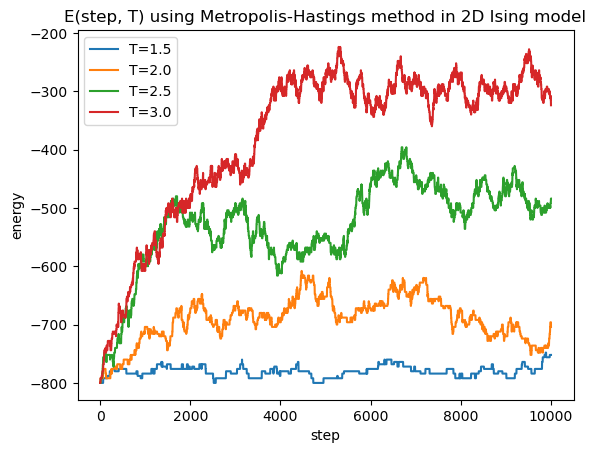

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt


def Metropolis_Hastings_2D(state: np.ndarray, beta, step, J=1):
    states = []
    for i in range(step):
        width, height = state.shape
        x = random.randint(0, width - 1)
        y = random.randint(0, height - 1)
        E_current = -J * (state[x][y] * state[(x + 1) % width][y] + state[x][y] * state[(x - 1) % width][y] + state[x][y] * state[x][(y + 1) % height] + state[x][y] * state[x][(y - 1) % height])
        E_proposed = -E_current
        delta_E = E_proposed - E_current
        if delta_E < 0:
            state[x][y] *= -1
        else:
            r = random.uniform(0, 1)
            if r < np.exp(-beta * delta_E):
                state[x][y] *= -1
        states.append(state.copy())
    return states


def Energy_2D(state: np.ndarray, J=1):
    energy = 0
    width, height = state.shape
    for x in range(width):
        for y in range(height):
            energy += -J * state[x][y] * (state[(x + 1) % width][y] + state[x][(y + 1) % height])
    return energy


L = 20
tempratures = [1.5, 2.0, 2.5, 3.0]
for temprature in tempratures:
    beta = 1 / temprature
    initial_state = np.ones((L, L), dtype=int)
    step = 10000
    states = Metropolis_Hastings_2D(initial_state, beta, step)
    energies = [Energy_2D(state) for state in states]
    step_list = list(range(step))
    plt.plot(step_list, energies, label=f'T={temprature}')
plt.xlabel('step')
plt.ylabel('energy')
plt.title('E(step, T) using Metropolis-Hastings method in 2D Ising model')
plt.legend()
plt.show()

T=1.5下，体系能量几乎不变，不怎么需要热化；T=2.0时，也不怎么要热化，大概要1000步；T=2.5时，热化大概要1000步；T=3.0时，热化大概要2000步。

**（2）一维伊辛模型：是否存在相变？**

考虑一维周期性伊辛链，长度为$L=100$：
$$
E = -J\sum_{i=1}^{L} s_i s_{i+1},\quad s_{L+1}\equiv s_1,\quad s_i=\pm 1.
$$

从$T=1.0$到$T=4.0$，每隔 0.2取一个点进行蒙特卡洛模拟。对于每个温度，在热平衡后计算并绘制平均磁化 ( $\langle |m(T)|\rangle$ ) 随温度的变化曲线（其中 $m=\frac{1}{L}\sum_i s_i$）。根据你的数值结果，判断在一维模型中随温度变化是否能观察到相变特征。

**Hint：**

对每个温度 (T)，从**全部自旋向上初态**出发，先进行预热，只更新不统计；在达到热平衡后，进行多步统计，每一步都记录瞬时磁化 $m(n)$，对这些数据做时间平均得到($\langle |m(T)|\rangle$)。把不同温度下得到的结果画成  ($|m(T)|$)–($T$) 曲线，观察是否存在某个温度附近磁化出现类似“突变”或“拐点”的行为。



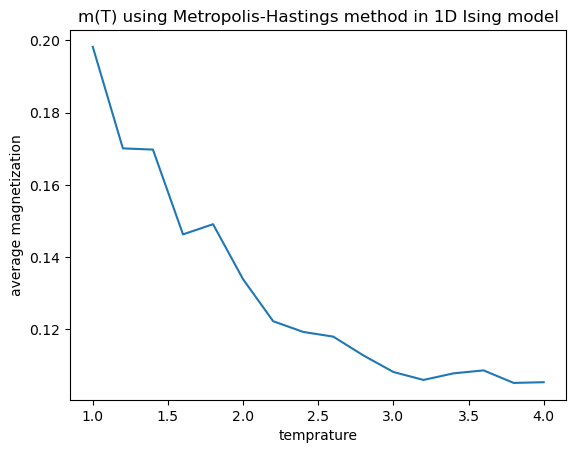

In [2]:
def Metropolis_Hastings_1D(state: np.ndarray, beta, step, J=1):
    states = []
    for i in range(step):
        width = state.size
        x = random.randint(0, width - 1)
        E_current = -J * state[x] * (state[(x + 1) % width] + state[(x - 1) % width])
        E_proposed = -E_current
        delta_E = E_proposed - E_current
        if delta_E < 0:
            state[x] *= -1
        else:
            r = random.uniform(0, 1)
            if r < np.exp(-beta * delta_E):
                state[x] *= -1
        states.append(state.copy())
    return states


def Magnetization_1D(state: np.ndarray):
    return abs(state.sum() / state.size)


L = 100
tempratures = np.arange(1.0, 4.1, 0.2)
magnetization_avgs = []
for temprature in tempratures:
    beta = 1 / temprature
    initial_state = np.ones(L, dtype=int)
    step = 100000
    step_statistic = 100000
    states = Metropolis_Hastings_1D(initial_state, beta, step + step_statistic)
    magnetizations = []
    for i in range(step, step + step_statistic):
        magnetizations.append(Magnetization_1D(states[i]))
    magnetization_avg = np.mean(magnetizations)
    magnetization_avgs.append(magnetization_avg)
plt.plot(tempratures, magnetization_avgs)
plt.xlabel('temprature')
plt.ylabel('average magnetization')
plt.title('m(T) using Metropolis-Hastings method in 1D Ising model')
plt.show()

图像很连续，并没有在某个温度处出现相变行为。

**（3）二维伊辛模型：观察相变**

回到二维零场Ising模型, 选取系统尺寸 $L=20$，从$T=1.0$到$T=4.0$，每隔 0.2取一个点进行蒙特卡洛模拟。对于每个温度，在热平衡后计算并绘制平均磁化 ( $\langle |m(T)|\rangle$ ) **随温度的变化曲线**。根据图像描述二维模型中相变的大致行为，是否能看出临界温度大致位置？1944 年，Onsager 给出了二维 Ising 模型的严格解，并指出在临界温度 $T_c = 2/\ln(1+\sqrt{2}) \approx 2.27$ 时，体系会发生自发对称性破缺，即系统会从顺磁相 ($m=0$) 变成铁磁相 ($|m|=1$)。请将你的相变点与之比较，并展示$T > T_c, T \approx T_c$ 和 $T < T_c$ **三个典型区域的系统自旋分布图** (不同颜色表示不同自旋）。


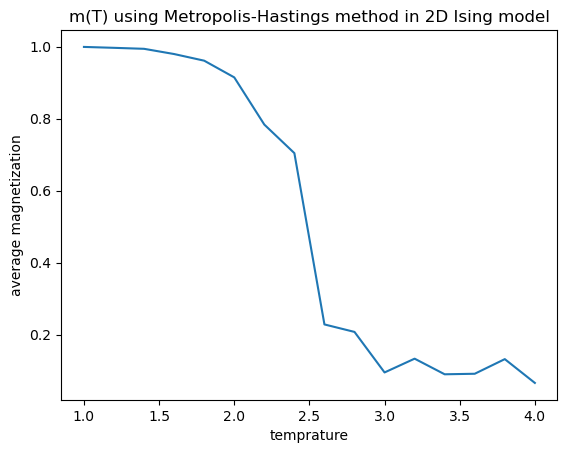

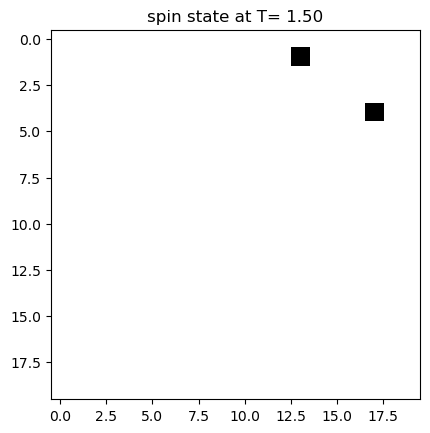

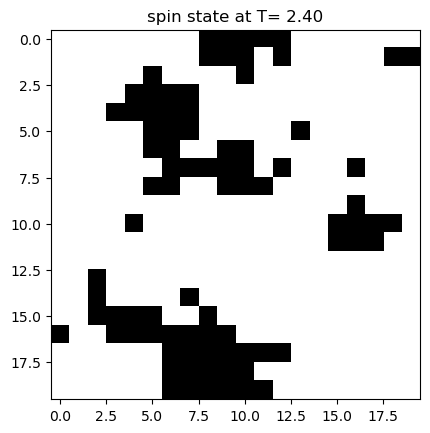

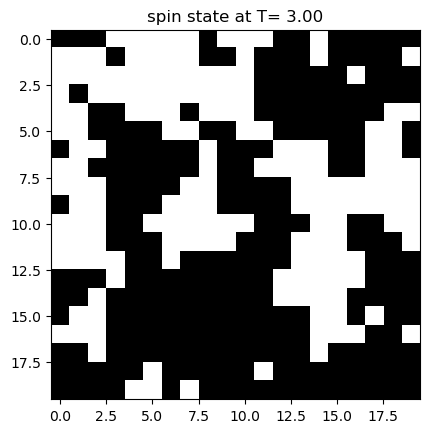

In [9]:
def Magnetization_2D(state: np.ndarray):
    return abs(state.sum() / state.size)


L = 20
tempratures = np.arange(1.0, 4.1, 0.2)
magnetization_avgs = []
for temprature in tempratures:
    beta = 1 / temprature
    initial_state = np.ones((L, L), dtype=int)
    step = 35000
    step_statistic = 20000
    states = Metropolis_Hastings_2D(initial_state, beta, step + step_statistic)
    magnetizations = []
    for i in range(step, step + step_statistic):
        magnetizations.append(Magnetization_2D(states[i]))
    magnetization_avg = np.mean(magnetizations)
    magnetization_avgs.append(magnetization_avg)
plt.plot(tempratures, magnetization_avgs)
plt.xlabel('temprature')
plt.ylabel('average magnetization')
plt.title('m(T) using Metropolis-Hastings method in 2D Ising model')
plt.show()

tempratures = [1.5, 2.4, 3.0]
magnetization_avgs = []
for temprature in tempratures:
    beta = 1 / temprature
    initial_state = np.ones((L, L), dtype=int)
    step = 10000
    states = Metropolis_Hastings_2D(initial_state, beta, step + step_statistic)
    final_state = states[-1]
    plt.imshow(final_state, cmap='gray')
    plt.title(f'spin state at T={temprature: .2f}')
    plt.show()

根据m(T)图像，可以看到临界温度在2.4附近。

**（4）二维伊辛模型：改变尺寸观察有限尺寸效应**

仍然考虑二维零场伊辛模型。现在希望通过改变系统尺寸，观察有限尺寸效应对相变行为的影响。选取三个不同的系统尺寸$L=5,10,20$，对每个L都在第（3）问中的温度点T上进行模拟，**在热平衡后计算并绘制$\langle |m(T,L)|\rangle$随温度的变化**。对比不同L的曲线，**观察并描述有限尺寸效应**。


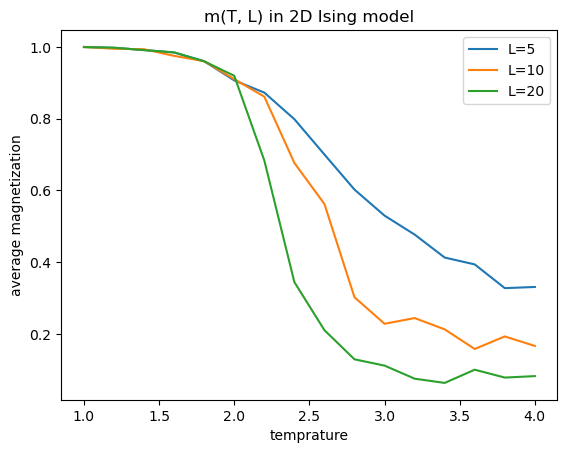

In [4]:
Ls = [5, 10, 20]
tempratures = np.arange(1.0, 4.1, 0.2)
for L in Ls:
    magnetization_avgs = []
    for temprature in tempratures:
        beta = 1 / temprature
        initial_state = np.ones((L, L), dtype=int)
        step = 35000
        step_statistic = 30000
        states = Metropolis_Hastings_2D(initial_state, beta, step + step_statistic)
        magnetizations = []
        for i in range(step, step + step_statistic):
            magnetizations.append(Magnetization_2D(states[i]))
        magnetization_avg = np.mean(magnetizations)
        magnetization_avgs.append(magnetization_avg)
    plt.plot(tempratures, magnetization_avgs, label=f'L={L}')
    plt.xlabel('temprature')
    plt.ylabel('average magnetization')
plt.legend()
plt.title('m(T, L) in 2D Ising model')
plt.show()

在L=5的时候，曲线非常平缓，很难分辨临界点；在L=10的时候，曲线稍微变陡；在L=20的时候更陡，可以勉强分辨临界点。

**(5)Wolff 算法的高效性与相变曲线对比**   
你可能会发现（3）中的曲线不是很平滑，这是因为在临界点附近，Metropolis 算法受困于临界慢化，需要极长的预热时间才能达到平衡。而 Wolff 聚类算法通过翻转宏观簇，能以少数步数迅速达到热平衡。请实现 Wolff 算法，再次计算二维 Ising 模型相变曲线（参数同3）。

**Hint：**  
Wolff 算法步骤：  
1.随机选取一个格点作为种子，加入簇中。  
2.检查簇中格点的最近邻：如果邻居与种子点自旋方向相同，则以概率 $P = 1 - e^{-2\beta J}$ 将其加入簇。  
3.重复生长过程，直到没有新成员加入。  
4.将簇内所有自旋同时翻转。

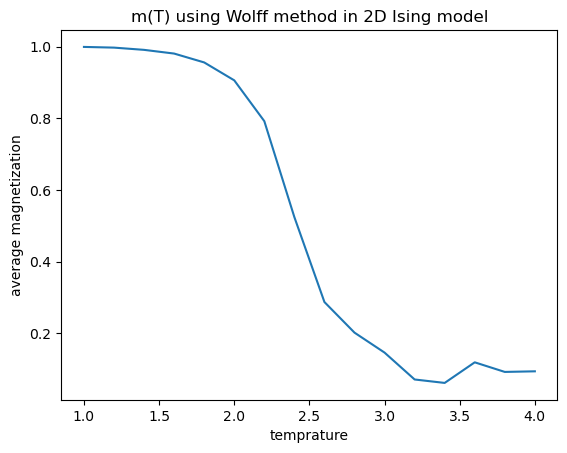

In [5]:
def Wolff_2D(state: np.ndarray, beta, step, J=1):
    states = []
    for i in range(step):
        width, height = state.shape
        x = random.randint(0, width - 1)
        y = random.randint(0, height - 1)
        cluster = set()
        cluster.add((x, y))
        stack = [(x, y)]
        while stack:
            cx, cy = stack.pop()
            for nx, ny in [((cx + 1) % width, cy), ((cx - 1) % width, cy), (cx, (cy + 1) % height), (cx, (cy - 1) % height)]:
                if (nx, ny) not in cluster and state[nx][ny] == state[cx][cy]:
                    r = random.uniform(0, 1)
                    p_add = 1 - np.exp(-2 * beta * J)
                    if r < p_add:
                        cluster.add((nx, ny))
                        stack.append((nx, ny))
        for cx, cy in cluster:
            state[cx][cy] *= -1
        states.append(state.copy())
    return states


L = 20
tempratures = np.arange(1.0, 4.1, 0.2)
magnetization_avgs = []
for temprature in tempratures:
    beta = 1 / temprature
    initial_state = np.ones((L, L), dtype=int)
    step = 1000
    step_statistic = 100
    states = Wolff_2D(initial_state, beta, step + step_statistic)
    magnetizations = []
    for i in range(step, step + step_statistic):
        magnetizations.append(Magnetization_2D(states[i]))
    magnetization_avg = np.mean(magnetizations)
    magnetization_avgs.append(magnetization_avg)
plt.plot(tempratures, magnetization_avgs)
plt.xlabel('temprature')
plt.ylabel('average magnetization')
plt.title('m(T) using Wolff method in 2D Ising model')
plt.show()

**（附加题）**
思考还可以探究Ising模型中的哪些物理量？请给出分析与结果。

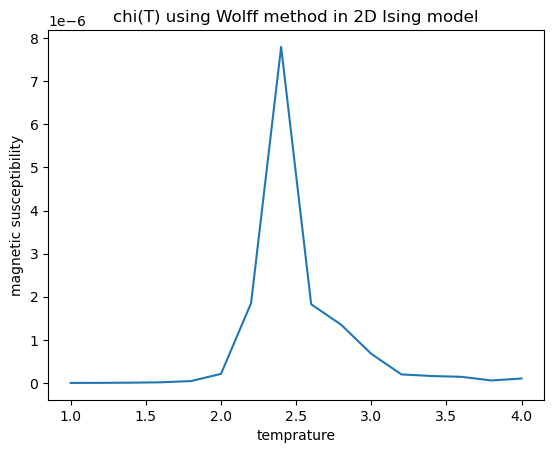

In [6]:
L = 40
tempratures = np.arange(1.0, 4.1, 0.2)
chis = []
for temprature in tempratures:
    beta = 1 / temprature
    initial_state = np.ones((L, L), dtype=int)
    step = 1000
    step_statistic = 200
    states = Wolff_2D(initial_state, beta, step + step_statistic)
    magnetizations = []
    square_magnetizations = []
    for i in range(step, step + step_statistic):
        magnetizations.append(Magnetization_2D(states[i]))
        square_magnetizations.append(Magnetization_2D(states[i]) ** 2)
    chi = beta * (np.mean(square_magnetizations) - np.mean(magnetizations) ** 2) / (L * L)
    chis.append(chi)
plt.plot(tempratures, chis)
plt.xlabel('temprature')
plt.ylabel('magnetic susceptibility')
plt.title('chi(T) using Wolff method in 2D Ising model')
plt.show()

如上所示，可以通过涨落耗散定理计算零场磁化率$\chi$，其在相变点会有发散峰（有限大体系下为尖锐的峰）。

### 作业完成情况：

本次作业用时约3小时，整体来说没有遇到卡太长时间的情况。一开始算了M的平均，而不是|M|的平均，发现图像在正负值之间来回跳就反应过来了。本次作业独立完成。